# Část 1 - aukce
Načtěte soubor “bids_train.csv”. Data obsahují záznamy z proběhlých aukcí. Prodejce nabízel reklamní prostor účastníkům aukce. V těchto aukcích soutěžili tři účastníci (bidders) A, B, a C, ale ne všichni se musí zúčastnit každé aukce. Hodnoty v tabulce jsou nabídky (bids) daného účastníka v dané aukci. Aukce je typu second-price; to znamená, že aukci vyhraje účastník s nejvyšší nabídkou a zaplatí druhou nejvyšší nabídku.

1. Spočítejte procenta výher pro každého účastníka. Tj. *počet aukcí, které vyhrál účastník A* děleno *celkový počet aukcí* atd.
2. Pro každou aukci určete cenu, kterou musel výherce zaplatit.
3. Jaký je celkový výnos prodejce ze všech aukcí?
4. Řekněme, že z pohledu prodejce jsou ceny náhodné veličiny. Zkuste odhadnout, jakým rozdělením pravděpodobnosti se ceny řídí.
5. Který účastník má nejvyšší ochotu platit?
6. Zobrazte vývoj ceny v čase (tj. ceny, kterou musel výherce zaplatit v každé aukci).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
df_bids = pd.read_csv("./bids_train.csv")
df_bids.describe()

,auction_id,A,B,C
count,400.000000,390.000000,394.000000,396.000000
mean,199.500000,7.338462,14.279188,31.452020
std,115.614301,18.778736,34.382717,38.596717
min,0.000000,0.000000,0.000000,2.000000
25%,99.750000,1.000000,3.000000,11.000000
50%,199.500000,3.000000,7.000000,20.000000
75%,299.250000,6.000000,14.000000,37.000000
max,399.000000,219.000000,563.000000,421.000000


In [3]:
# auction_id is de facto the index -> redundant column
df_bids.index = df_bids.auction_id
df_bids.drop("auction_id", axis=1, inplace=True)

In [4]:
# get NaN counts
df_bids.isna().sum()

time     0
A       10
B        6
C        4
dtype: int64

Assuming `NaN` represents a bidder not taking part in the auction and `0` is a legitimate bid.

In [5]:
void_auctions = df_bids.query('(A.isnull() & B.isnull()) | (A.isnull() & C.isnull()) | (B.isnull() & C.isnull())')
void_auctions

,time,A,B,C
auction_id,,,,
8,2020-01-01 00:05:46,3.0,NaN,NaN
25,2020-01-01 00:18:01,NaN,NaN,241.0


There appear to be auctions where only one bid was placed - this is not allowed in second-price auctions and those instances will be void.

In [6]:
df_bids.drop(void_auctions.index, axis=0, inplace=True)

## Q1.1

In [7]:
bidders = ['A', 'B', 'C']

In [8]:
# get the count of auctions a bidder took part in
auction_counts = df_bids[bidders].count()
auction_counts

A    389
B    394
C    395
dtype: int64

In [9]:
# get the winner of each auction
winners = df_bids[bidders].idxmax(axis=1)
win_counts = winners.value_counts().sort_values()
win_counts

A     30
B     90
C    278
dtype: int64

In [10]:
print("Win rate:")
# the sum does not add up to 100, as each bidder took part in a different number of auctions
for bidder in bidders:
    win_rate_perc = win_counts[bidder] / auction_counts[bidder] * 100
    print("  Bidder %s: %.2f%%" % (bidder, win_rate_perc))

Win rate:
  Bidder A: 7.71%
  Bidder B: 22.84%
  Bidder C: 70.38%


## Q1.2

In [11]:
# get the price (the second largest value)
def get_price_to_pay(bids_dataframe):
    return bids_dataframe[bidders].apply(lambda row: row.nlargest(2).values[-1], axis=1)
prices_paid = get_price_to_pay(df_bids)
prices_paid

auction_id
0       6.0
1       3.0
2       3.0
3      12.0
4      14.0
       ... 
395     2.0
396     9.0
397     2.0
398     3.0
399    17.0
Length: 398, dtype: float64

## Q1.3

In [12]:
print("Total revenue: %.2f" % sum(prices_paid))

Total revenue: 4186.00


## Q1.4

First visualize the raw data...

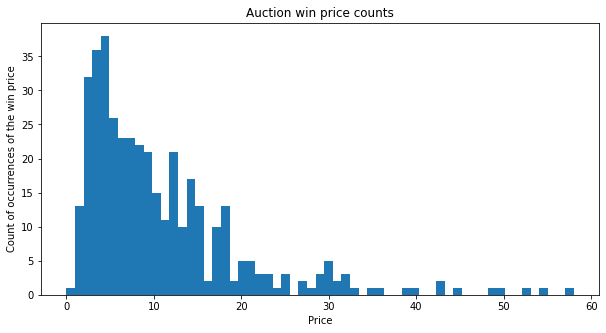

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Auction win price counts")
bars = plt.hist(prices_paid, bins=int(max(prices_paid)+1))
plt.xlabel("Price")
plt.ylabel("Count of occurrences of the win price")
plt.show()

To my best knowledge, there does not seem to be to be a simple way to estimate to obtain a probability distribution and its parameters from a sample.

From a computer science point of view, the most intuitive approach seems to be trying to fit "candidate" distributions with the data I have, evaluate the picks (here using [Kolmogorov-Smirnov test](https://www.tandfonline.com/doi/abs/10.1080/01621459.1951.10500769)) and select the best one.

In [14]:
import scipy.stats as st
import warnings

# ignore warnings from data that can't be fit
warnings.filterwarnings('ignore')

# Inspired by: https://stackoverflow.com/q/37487830
def get_best_distribution(data):
    # list of candidate distributions
    dist_candidates = [st.alpha, st.beta, st.chi, st.chi2, st.genextreme, st.invgamma, st.norm, st.pareto]
    dist_results, dist_params = {}, {}
    # try all the candidates
    for dist in dist_candidates:
        # compute the fit
        param = dist.fit(data)
        # store parameters
        dist_params[dist.name] = param

        # evaluate the candidate using Kolmogorov-Smirnov test
        # picking the one that minimises D, the test statistic
        #   = difference between the sample and the fit
        D, p = st.kstest(data, dist.name, args=param)
        print("D for %s = %.8f" % (dist.name, D))
        dist_results[dist.name] = D

    # select the best fitted distribution
    best_dist = min(dist_results, key=dist_results.get)

    print("\nBest fitting distribution: %s" % best_dist)
    print("Best D value: %s" % dist_results[best_dist])
    print("Parameters for the best fit:")
    for param, val in zip(['a', 'b', 'loc', 'scale'], dist_params[best_dist]):
        print("  %s = %s" % (param, val))
    print()
    
    return best_dist, dist_params[best_dist]

dist_name, (a, b, loc, scale) = get_best_distribution(prices_paid)

D for alpha = 0.33613796
D for beta = 0.07051271
D for chi = 0.09711384
D for chi2 = 0.09718584
D for genextreme = 0.07633639
D for invgamma = 0.07444244
D for norm = 0.15436687
D for pareto = 0.16447579

Best fitting distribution: beta
Best D value: 0.07051270810316615
Parameters for the best fit:
  a = 1.5118025433094977
  b = 1086926.3778940248
  loc = -0.029873609806954957
  scale = 7624803.845521534



Given the pool of possible distributions (obviously can be extended), the best fitting distribution for the underlying dataset seems to be **Beta distribution** with the **a, b** parameter values above.

To test the correctness of the fit, visualize the probability distribution function on normed histogram of the data.

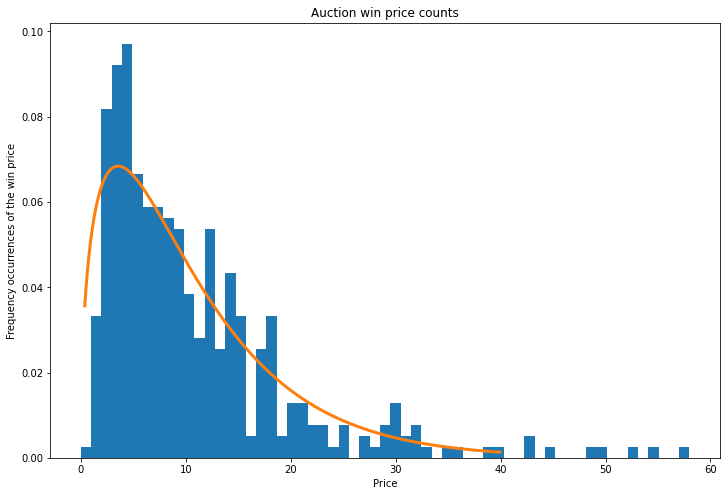

In [15]:
# plot the original histogram
bars = plt.hist(prices_paid, bins=int(max(prices_paid)+1), density=True)

# make start and end points of distribution
start = st.beta.ppf(0.01, a=a, b=b, loc=loc, scale=scale)
end = st.beta.ppf(0.99, a=a, b=b, loc=loc, scale=scale)
# create 1000 samples, build PDF and turn it into pandas Series
x = np.linspace(start, end, 1000)
y = st.beta.pdf(x, a=a, b=b, loc=loc, scale=scale)
pdf = pd.Series(y, x)
# plot the results
ax = pdf.plot(lw=3, label='PDF')

ax.set_title("Auction win price counts")
plt.xlabel("Price")
plt.ylabel("Frequency occurrences of the win price")
plt.show()

## Q1.5

There are several ways to look at this problem, all valid depending on the use case.

Assumming that all bidders are rational, by definition they will never place bids higher than their willingness to pay. And because second-price auctions are sealed-bid type auction, with a risk-neutral approach it is optimal to bid the price equal to one's reservation price - here, the willingness to pay.

Therefore, the bidder that has won the most auctions has the highest willingness to pay - here, **bidder 'C'** (#1).

It is also valid to consider the cummulative amount of money a bidder has placed on all auctions. Assumming that the most significant auctions are valued the highest, the desire to pay a large amount of money on (several) individual auctions also denotes willingness to pay.

Again in this case, **bidder 'C'** has the highest willingness to pay (#2).

Lastly, it might be valuable to evaluate the amount of money a bidder has spent on average per an auction won. Higher values signify that a bidder has a high willingness to pay for auctions that are important to them. This could be a valuable indicator when setting up auctions.

For that scenario, **bidder 'A'** has the highest willingness to pay (#3).


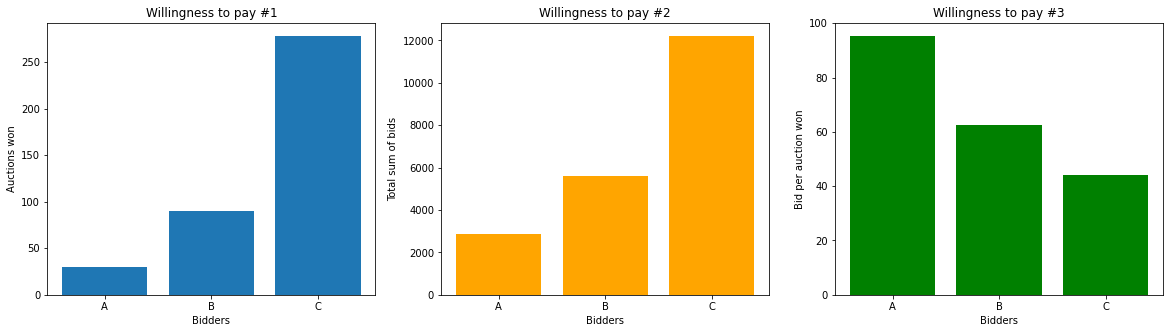

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.subplot(1,3,1)
plt.title("Willingness to pay #1")
plt.bar(bidders, win_counts)
plt.xlabel("Bidders")
plt.ylabel("Auctions won")

plt.subplot(1,3,2)
plt.title("Willingness to pay #2")
plt.bar(bidders, df_bids[bidders].sum(), color='orange')
plt.xlabel("Bidders")
plt.ylabel("Total sum of bids")

plt.subplot(1,3,3)
plt.title("Willingness to pay #3")
plt.bar(bidders, df_bids[bidders].sum()/win_counts, color='green')
plt.xlabel("Bidders")
plt.ylabel("Bid per auction won")

plt.show()

## Q1.6

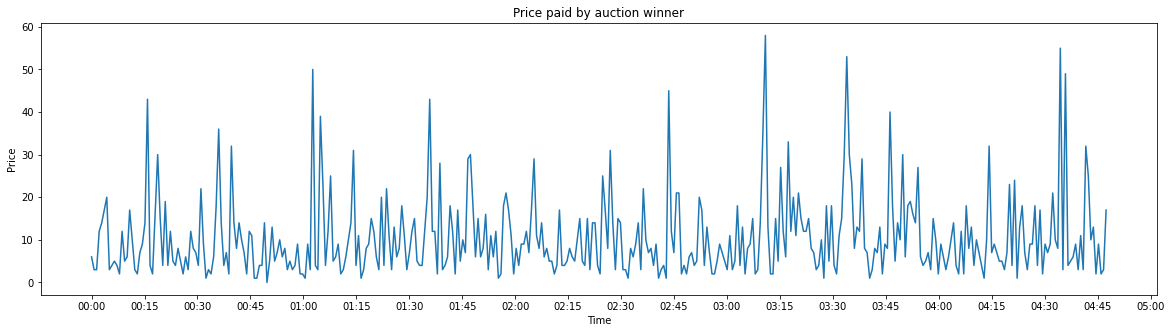

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title("Price paid by auction winner")
plt.plot(pd.to_datetime(df_bids['time']), prices_paid)
plt.xlabel("Time")
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45], interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
plt.ylabel("Price")
plt.show()

# Část 2 - online aukce

V aukcích internetové reklamy jsou účastníci aukce inzerenti, dražený objekt je reklamní prostor a prodejcem je vlastník reklamního prostoru. Inzerenti soutěží o zobrazení své reklamy v reklamním prostoru a platí pouze tehdy, když je jejich reklama zobrazena a návštěvník internetové stránky na ni klikne. Proto se v online aukcích výherce neurčuje pouze podle nabízené ceny, ale podle násobku nabízené ceny a pravděpodobnosti prokliku.

Načtěte soubor “factors_train.csv”, který obsahuje historická data o odhadech pravděpodobností prokliku a faktorech, které tuto pravděpodobnost ovlivňují. Sloupec “click” říká, jestli daná reklama obdržela klik nebo ne. U kandidátů, kteří prohráli v aukci, je automaticky 0. Výherce aukce se potom zobrazí v reklamním prostoru, ale i tak dostane klik jen s určitou pravděpodobností.

1. Jaké vlivy podle Vás zachycují faktory 1 a 2?
2. Spojte tato data s daty o nabízených cenách. Pro každou aukci a každého účastníka
spočítejte *online bid = nabízená cena * pravděpodobnost prokliku*.

3. Určete výherce každé aukce, tentokrát podle online bidu. Spočítejte, v kolika
procentech případů vyhrál každý nabízející. Jak se tyto poměry změnily oproti předchozímu případu, kdy jsme uvažovali jen nabízenou cenu? Čím může být rozdíl způsoben?

4. V online aukcích se cena, kterou má zaplatit výherce aukce, počítá podle následujícího pravidla:

p.p. = pravděpodobnost prokliku

konečná cena za proklik = *p.p. druhého v pořadí děleno p.p. prvního v pořadí krát nabízená cena druhého*

Tuto cenu platí výherce pouze tehdy, pokud získal i klik. Můžete si všimnout, že
finální cena nezávisí na nabízené ceně daného inzerenta.

5. Spočítejte celkový výnos z aukce.

In [18]:
df_factors = pd.read_csv("./factors_train.csv")
df_factors.describe()

,auction_id,factor_1,factor_2,prob,click
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,202.150847,2.047663,10.404264,0.010204,0.005932
std,114.613875,1.275833,0.766588,0.021201,0.076825
min,0.000000,-1.834772,8.046086,0.000080,0.000000
25%,104.750000,1.191992,9.886013,0.001731,0.000000
50%,203.000000,1.978507,10.467145,0.004269,0.000000
75%,301.000000,2.945106,10.934544,0.010586,0.000000
max,399.000000,6.149047,12.968965,0.416378,1.000000


## Q2.1

The are many factors affecting how per-click bids are weighted. For example with textual ads, ads that have a bid on a keyword go to "auction" once the keyword is searched and try to rank higher than the other competitors based on relevancy and user-experience.

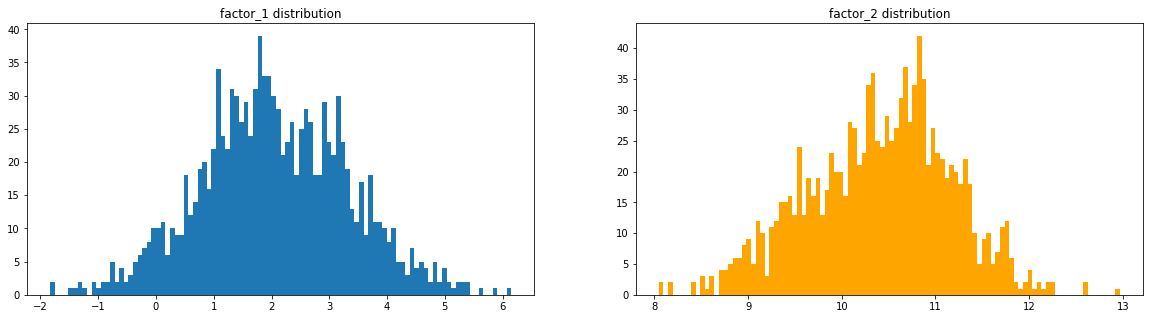

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.subplot(1,2,1)
plt.title("factor_1 distribution")
plt.hist(df_factors['factor_1'], bins=100)

plt.subplot(1,2,2)
plt.title("factor_2 distribution")
plt.hist(df_factors['factor_2'], bins=100, color='orange')
plt.show()

Factors are determined by specific strategy of the advertising platform. The overall price is then a combination of such factors and how the competitors perform. `factor_1` and `factor_2` can then represent many platform-specific indicators, such as:

* ad text
* keywords (relevance, quality)
* landing page (relevance, quality)
* bid placed
* maximum bid
* target demographics
* seasonality

Given the distribution of `factor_1` and higher standard deviation, this could perhaps be the indicator for the **relevance of the ad text**, as there is might a higher variation in the possible ad text combinations and their fit for the auction. In terms of `factor_2`, it might indicate a more constrained variable, given the smaller variation in the set of values, perhaps the **keywords quality**.

## Q2.2

Get click probabilities of each bidder for each `auction_id` in one nice dataframe.

In [20]:
def get_click_probs(factors_dataframe, void_auctions_ids=None):
    def get_bidder_prob(frame, bidder_id):
        bidder_prob = frame[frame['bidder_id'] == bidder_id][['auction_id', 'prob']]
        bidder_prob.index = bidder_prob.auction_id
        bidder_prob.drop("auction_id", axis=1, inplace=True)
        bidder_prob.rename(columns={'prob': bidder_id}, inplace=True)
        return bidder_prob

    click_probs = pd.concat([get_bidder_prob(factors_dataframe, bidder) for bidder in bidders], axis=1)
    
    if void_auctions_ids is not None:
        # drop the illegal rows identified in df_bids
        click_probs.drop(void_auctions_ids, axis=0, inplace=True)
        
    return click_probs

click_probs = get_click_probs(df_factors, void_auctions_ids=void_auctions.index)
# sanity check
pd.testing.assert_series_equal(auction_counts, click_probs.count())

In [21]:
online_bids = click_probs * df_bids[bidders]
online_bids

,A,B,C
auction_id,,,
0,0.002670,0.000000,0.102121
1,0.064562,0.004892,0.049921
2,0.005545,0.039800,0.007864
3,0.076420,1.185770,0.014081
4,0.193012,0.014160,0.065772
...,...,...,...
395,0.011547,0.006289,0.017397
396,0.053928,0.001671,0.012543
397,0.002689,0.013756,0.001857


## Q2.3

In [22]:
# get the winner of each auction
online_winners = online_bids[bidders].idxmax(axis=1)
online_win_counts = online_winners.value_counts().sort_values()
online_win_counts

A    108
B    134
C    156
dtype: int64

In [23]:
print("Online win rate:")
# he sum does not add up to 100, as each bidder took part in a different number of auctions
for bidder in bidders:
    win_rate_perc = online_win_counts[bidder] / auction_counts[bidder] * 100
    print("  Bidder %s: %.2f%%" % (bidder, win_rate_perc))

Online win rate:
  Bidder A: 27.76%
  Bidder B: 34.01%
  Bidder C: 39.49%


When comparing with the results of second-price auctions, we can see that the percentual win rates of the bidder are now much more similar. To help explain the difference, we can perhaps have a look at Willingness to Pay charts 2 & 3 from [question 1.5](##-Q1.5).

Here we can see that bidder C, who has won 70%+ of second-price auctions has by far spent the most money bidding (cummulatively). Given the format, their overbidding secured them the win in majority of the cases, without having to actually pay the bid. This might indicate that bidder C correctly identified the behaviour of competitors in second-price auctions.

However, since the format is different here, other factors now determine the winner of the auction. While the strategy paid off for bidder C previously, for this format, the roles have actually reversed. Now, despite still having won the most auctions, the average price paid for an auction won here is almost three time the one of bidder A, yet with a win rate only ~12% higher.

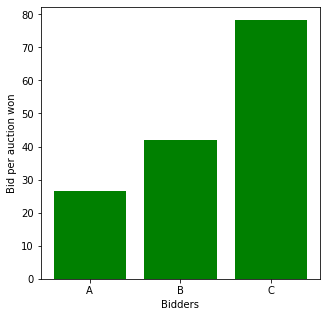

In [24]:
plt.subplots(figsize=(5, 5))
plt.bar(bidders, df_bids[bidders].sum()/online_win_counts, color='green')
plt.xlabel("Bidders")
plt.ylabel("Bid per auction won")

plt.show()

## Q2.4

Formula for the price of a click in an online auction:

$click\ price = \frac{2^{nd}\ place\ click\ proba}{1^{st}\ place\ click\ proba} * 2^{nd}\ place\ bid$

In [25]:
def get_click_price(bids_dataframe, factors_dataframe, void_auctions_ids=None):
    # get the winners and runner-ups of each auction
    first_places = bids_dataframe[bidders].apply(lambda x: x.nlargest(1).idxmin(), axis=1)
    second_places = bids_dataframe[bidders].apply(lambda x: x.nlargest(2).idxmin(), axis=1)
    # get the bid of the runner-ups (i.e. second-price auction prices)
    second_places_bid = get_price_to_pay(bids_dataframe)
    # get the click probability of winners and runner-ups in each auction
    click_probs = get_click_probs(factors_dataframe, void_auctions_ids)
    first_places_probs = click_probs.lookup(click_probs.index, first_places)
    second_places_probs = click_probs.lookup(click_probs.index, second_places)
    # compute the formula
    return second_places_probs / first_places_probs * second_places_bid
    
click_prices = get_click_price(df_bids, df_factors, void_auctions_ids=void_auctions.index)
click_prices

auction_id
0       0.810394
1       2.253960
2      35.426544
3       2.006868
4      96.840329
         ...    
395    16.593144
396    51.593046
397     1.350031
398     8.813160
399    27.079390
Length: 398, dtype: float64

## Q2.5

A bidder only pays for an auction if it received a click. Therefore, the total revenue of the advertising platform is computed only from the auctions that received a click.

In [26]:
df_factors[df_factors.click == 1]

,auction_id,bidder_id,time,factor_1,factor_2,prob,click
115,42,A,2020-01-01 00:30:15,2.272395,10.412868,0.041497,1.0
362,127,B,2020-01-01 01:31:29,2.813895,11.384459,0.049545,1.0
396,138,C,2020-01-01 01:39:25,2.065812,10.505335,0.034759,1.0
565,195,A,2020-01-01 02:20:28,3.133862,9.737248,0.077589,1.0
753,257,C,2020-01-01 03:05:08,1.192076,11.553206,0.013200,1.0
800,273,B,2020-01-01 03:16:39,3.859351,9.549556,0.115028,1.0
979,333,A,2020-01-01 03:59:53,4.325153,10.510823,0.121772,1.0


In [27]:
# sanity check that the online winners computed correspond with the ones in the given df
successful_auction_ids = df_factors[df_factors.click == 1].auction_id
successful_bidder_ids = df_factors[df_factors.click == 1].bidder_id
np.testing.assert_array_equal(online_winners[successful_auction_ids].to_numpy(),
                              successful_bidder_ids.to_numpy())

print("Total revenue: %.2f" % sum(click_prices[successful_auction_ids]))

Total revenue: 197.17


# Část 3 - model

V určitých fázích projektu může být úkolem výzkumníků vytvořit model, který bude řešit nějakou produktovou potřebu. Takový model musí být výzkumník schopen definovat, natrénovat, vyhodnotit a aplikovat.
Za použití dat ze souboru `factors_train.csv`:

1. Formulujte a odhadněte model predikce pravděpodobnosti prokliku (label = “prob”). Reportujte údaje o modelu - odhadovaná rovnice, odhadnuté parametry.

2. Formulujte a odhadněte model predikce kliku na reklamu, pokud je reklama zobrazena resp. vyhrála aukci (label = “click”). Reportujte údaje o modelu - odhadovaná rovnice, odhadnuté parametry.

    2.1. Vyhodnoťte kvalitu modelu (přesnost predikce kliku)

3. Načtěte soubory “bids_test.csv” a “factors_test.csv”, které obsahují podobná data, nicméně tentokrát bez odhadnutých pravděpodobností prokliku.
    
    3.1. Použijte model odhadnutý v bodu 2. (?**1.**?) k predikci pravděpodobnosti prokliku.
    
    3.2. Jaký je očekávaný celkový výnos z těchto nových aukcí?

4. Vyhodnoťte kvalitu modelu na datovém souboru “factors_test.csv”, porovnejte ji vůči výsledku z bodu 2.1. a výsledky zkuste interpretovat.

In [28]:
df_factors.head()

,auction_id,bidder_id,time,factor_1,factor_2,prob,click
0,0,A,2020-01-01 00:00:00,3.133335,9.753830,0.000445,0.0
1,0,B,2020-01-01 00:00:00,1.665116,9.709080,0.001695,0.0
2,0,C,2020-01-01 00:00:00,0.903419,9.632183,0.003294,0.0
3,1,A,2020-01-01 00:00:43,5.409922,9.305300,0.064562,0.0
4,1,B,2020-01-01 00:00:43,1.696985,9.155841,0.001631,0.0


## Q3.1

**Approach: Linear regression** (with multiple predictors Multiple linear regression).

There are some assumptions that must be met to obtain a quality model.

1. Multicollinearity: Verifies that predictors are not correlated with each other;
2. Linearity: Assumes that there is a linear relationship between the predictors and the response variable;
3. Normality: Assumes that the error terms (residuals) are normally distributed;
4. Homoscedasticity: Assumes that the errors exhibit constant variance.

In [30]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import zscore
from statsmodels.stats.diagnostic import normal_ad

In [31]:
# all features identified that might be useful (+ label)
XY_names = ['bidder_id', 'factor_1', 'factor_2'] + ['prob']
dataset = df_factors[XY_names]
# onehot-encode bidders
dataset = pd.get_dummies(dataset, columns=['bidder_id'], prefix='bidder')

Assumption - Little to no multicollinearity among predictors:


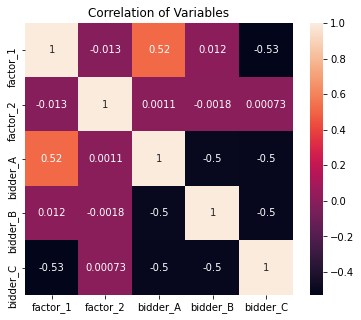

In [32]:
# Multicollinearity assumption check
def multicollinearity_assumption(features, feature_names=None):
    print('Assumption - Little to no multicollinearity among predictors:')
        
    # Plotting the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
    
multicollinearity_assumption(dataset, ['factor_1', 'factor_2', 'bidder_A', 'bidder_B', 'bidder_C'])

There seems to be a correlation between the one-hot encoded predictors. This is common for categorical variables. There also seems to be a correlation among `bidder_A & factor_1`, and `bidder_C & factor_1`. More checks could be done, but removing one-hot encoded predictors has not negatively impacted the performance of the model later...

Assumption - Little to no multicollinearity among predictors:


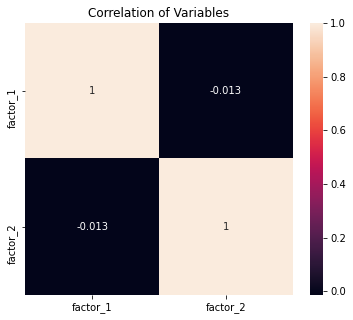

In [33]:
# remaining features (+ label)
XY_names = ['factor_1', 'factor_2', 'prob']
dataset = df_factors[XY_names]
multicollinearity_assumption(dataset, ['factor_1', 'factor_2'])

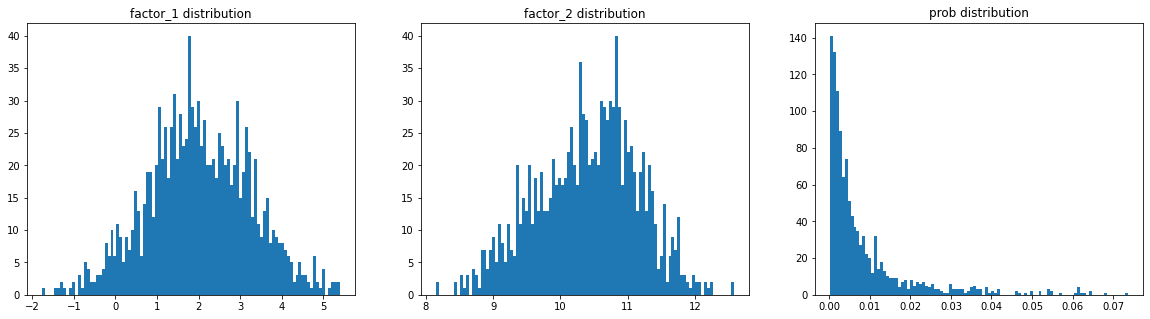

In [34]:
# Remove outliers:
# 1. compute z-score for every relevant columns
# 2. take the absolute value (direction does not matter) and keep values below threshold
zscore_thresh = 3
dataset = dataset[(np.abs(zscore(dataset)) < zscore_thresh).all(axis=1)]

# plot distribution of features and label
fig, ax = plt.subplots(figsize=(20, 5))
for i, col in enumerate(XY_names):
    plt.subplot(1, len(XY_names), i+1)
    plt.title("%s distribution" % col)
    plt.hist(dataset[col], bins=100)

`factor_1` and `factor_2` seem to be somewhat normally distributued. However, `prob` values are exponentially distributed. While this is not required, it might help to log-transform the values of the label for model evaluation and later apply inverse function on top of the predicted values to get the actual predicted target value.

In [35]:
# standardizing features isn't needed as everything has almost normal distribution
# dataset = StandardScaler().fit_transform(dataset)
# dataset = pd.DataFrame(data=dataset, columns=XY_names)

# RETROSPECTIVE CHANGE (see below): normalize features
X = normalize(dataset[['factor_1', 'factor_2']], norm='max', axis=0)
Y = dataset[['prob']]

# log-transform target values
Y = np.log(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

**RETROSPECTIVE CHANGE:**

`factor_1` & `factor_2` values in the test file are distributed the same way as in the train file. *However*, they appear to be scaled up roughly by the factor of 10. Therefore, normalization is applied to each feture of `X`.

In [36]:
# Ordinary least squares - Lasso / Ridge seem to bring little improvement
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

# NOTE: Evaluation on log-transformed values
print("MSE: %.5f" % mean_squared_error(Y_test, Y_pred))
print("MAE: %.5f" % mean_absolute_error(Y_test, Y_pred))
print('R^2: %.5f' % r2_score(Y_test, Y_pred))

MSE: 0.88237
MAE: 0.73790
R^2: 0.46656


Assumption - Linear Relationship between the Target and the Feature:
Predictions should follow the diagonal line.


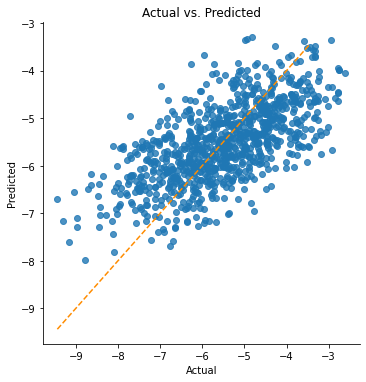

In [37]:
# Helper function
def calculate_residuals(model, features, labels):
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': labels.to_numpy().flatten(), 'Predicted': predictions.flatten()})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results

# Linearity assumption check
def linear_assumption(model, features, labels):
    print('Assumption - Linear Relationship between the Target and the Feature:')
    print('Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, labels)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=5)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results[['Actual','Predicted']].min().min(),
                            df_results[['Actual','Predicted']].max().max())
    plt.plot(line_coords, line_coords, color='darkorange', linestyle='--') 
    plt.title('Actual vs. Predicted')
    plt.show()

linear_assumption(lr, X_train, Y_train)

The relationship is linear but not perfecty: The predictions seem to be biased towards higher values at the lower end, and slightly towards lower values at the higher end.

Assumption - The residuals are normally distributed:
p-value from the test - below 0.05 generally means non-normal: 0.004957062942211427


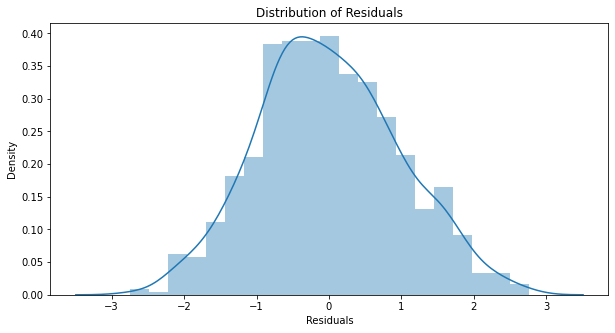

In [38]:
# Normality assumption check
def normal_errors_assumption(model, features, labels, p_value_thresh=0.05):
    print('Assumption - The residuals are normally distributed:')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, labels)
    
    # Performing the Anderson-Darling test for normal distribution on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(10, 5))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()

normal_errors_assumption(lr, X_train, Y_train)

With the results of the Anderson-Darling test & the plot, we can see that this is not ideal and that the model is slightly biased towards underestimating.

Assumption - Homoscedasticity of Error Terms:
Residuals should have relative constant variance


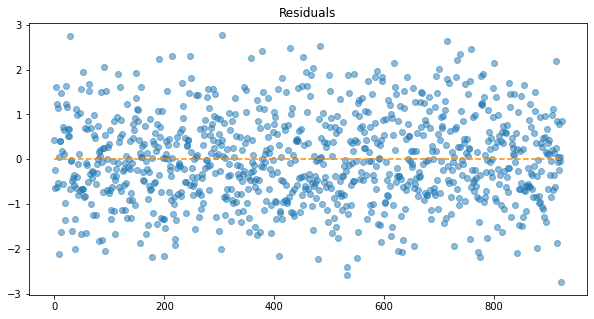

In [39]:
# Homoscedasticity assumption check
def homoscedasticity_assumption(model, features, labels):
    print('Assumption - Homoscedasticity of Error Terms:')
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, labels)
    
    # Plotting the residuals
    plt.subplots(figsize=(10, 5))
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    plt.title('Residuals')
    plt.show()  
    
homoscedasticity_assumption(lr, X_train, Y_train)

There does not seem to be any apparent problem with this assumption.

In [40]:
print("The coefficients are %f, %f:" % (lr.coef_[0][0], lr.coef_[0][1]))
print("The intercept is %f:" % lr.intercept_)

The coefficients are 3.511819, 3.159070:
The intercept is -9.438290:


Given that we have log-transformed the label, we need to inverse the operation. The model can be ultimately described as:

$$\Large \mathrm{prob}\;=\;e^{(3.511819\;*\;\mathrm{frac\_1}\;+\;3.159070\;*\;\mathrm{frac\_2}\;-\;9.438290)}$$

## Q3.2

Predicting a 0/1 value denotes a binary classification task.

It would make sense to include `prob` as a prediction attribute as well, however for this project, it might be hard to verify the model on the test dataset in the final question, considering that the `prob` value is predicted by the previous model and therefore affected by its quality.

In [41]:
features = ['factor_1', 'factor_2']
X = df_factors[features]
Y = df_factors['click']

# representation of samples in the dataset
Y.value_counts()

0.0    1173
1.0       7
Name: click, dtype: int64

Unfortunately, the issue here is that dataset is extremely unbalanced (~167:1), which poses a significant problem for learning.

There are many was this can be dealt with:

1. Collect more data (not possible here);
2. Undersampling/undersamping of instances;
3. Generating synthetic samples;
4. Included weights;
...

Based on [this paper](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf) by Breiman (author of Random Forests), **Weighted Random Forests** were considered as an approach as they have performance superior to most of the techniques examined by the paper. *However*, this has resulted in unsatisfying performance, as the scale of the unbalancedness would cause the training instance to overfit.

In [42]:
def print_confusion_matrix(confusion_matrix):
    class_names = ['Not Click', 'Click']
    df_cm = pd.DataFrame(confusion_matrix,
                         index=['True %s' % c for c in class_names],
                         columns=['Pred %s' % c for c in class_names])
    display(df_cm)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.33,
                                                    random_state=RANDOM_STATE)

# because the classes are imbalanced, we need to compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=np.ravel(Y_train))

clf_balanced = RandomForestClassifier(criterion='entropy',
                                      class_weight={c: class_weights[c] for c in [0, 1]},
                                      random_state=RANDOM_STATE,
                                      n_estimators=50,
                                      min_samples_split=5,
                                      n_jobs=-1)
clf_balanced.fit(X_train, Y_train)
Y_pred = clf_balanced.predict_proba(X_test)[:, 1]

print('F1 Score: ', f1_score(Y_test, np.round(Y_pred)))
print('AUC:      ', roc_auc_score(Y_test, Y_pred))

print_confusion_matrix(confusion_matrix(Y_train, np.round(clf_balanced.predict_proba(X_train)[:, 1])))
print_confusion_matrix(confusion_matrix(Y_test, np.round(Y_pred)))

F1 Score:  0.0
AUC:       0.6236003445305771


,Pred Not Click,Pred Click
True Not Click,786,0
True Click,0,4


,Pred Not Click,Pred Click
True Not Click,387,0
True Click,3,0


Instead, the approach chosen was to randomly sample the attributes from instances in the minority class under the assumption of underlying normal distribution. This was achieved using **Kernel density estimation** that created synthetic positive instances from the existing underreprested instances that were used to train the model. The quality of the model was verified using the real positive instance, that have not appeared in the training set. Still, this approach has the risk of overfitting if the synthetic samples are too closely resembling the real samples. The smoothness of the fit is controlled by the `bandwith` parameter.

The choice of `bandwith` parameter, alongside with hyperparameter values for the model were obtained using **Grid Search**.

In [44]:
# hyperparams = {'n_estimators': [5, 10, 20, 30, 50, 75, 100, 200, 500, 1000],
#                'min_samples_split': [2, 3, 4, 5, 7, 10, 20],
#                'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10],
#                'criterion': ['gini', 'entropy']}

# grid_search = GridSearchCV(
#     RandomForestClassifier(
#         random_state=RANDOM_STATE,
#         n_jobs=-1),
#     hyperparams,
#     scoring='f1')
# grid_search.fit(X_train, Y_train)

In [45]:
X_pos = df_factors[df_factors['click'] == 1][features]   # values of X where click == 1
X_neg = df_factors[df_factors['click'] == 0][features]   # values of X where click == 0

# Fit a kernel density model with underrepresented class
kde = KernelDensity(bandwidth=0.2)
kde.fit(X_pos)
# Sample synthetic positive data in the size of the actual negative data,
# so that we have a balanded training set
X_pos_sampled = kde.sample(len(X_neg), random_state=RANDOM_STATE)
# Create a training dataset
X_train = np.vstack((X_neg, X_pos_sampled))
# Add appropriate labels
Y_train = np.array([0] * len(X_neg) + [1] * len(X_pos_sampled))
# Shuffle the training set
p = np.random.RandomState(seed=RANDOM_STATE).permutation(len(X_train))
X_train, Y_train = X_train[p], Y_train[p]

clf = RandomForestClassifier(criterion='gini',
                             random_state=RANDOM_STATE,
                             n_estimators=100,
                             min_samples_split=3,
                             n_jobs=-1)
clf.fit(X_train, Y_train)

print("Performance on training data:")
Y_pred_train = clf.predict_proba(X_train)[:, 1]
print('  F1 Score:', f1_score(Y_train, np.round(Y_pred_train)))
print('  AUC:     ', roc_auc_score(Y_train, Y_pred_train))
print_confusion_matrix(confusion_matrix(Y_train, np.round(Y_pred_train)))

# Verify the performance on the real dataset
print("\nPerformance on real data:")
Y_pred = clf.predict_proba(X)[:, 1]
print('  F1 Score:', f1_score(Y, np.round(Y_pred)))
print('  AUC:     ', roc_auc_score(Y, Y_pred))
print_confusion_matrix(confusion_matrix(Y, np.round(Y_pred)))

Performance on training data:
  F1 Score: 0.9995739241585002
  AUC:      1.0


,Pred Not Click,Pred Click
True Not Click,1172,1
True Click,0,1173



Performance on real data:
  F1 Score: 0.8571428571428571
  AUC:      0.9851418828400925


,Pred Not Click,Pred Click
True Not Click,1172,1
True Click,1,6


The resulting model offers quality prediction performance on the real data. It outperforms the baselines, a naive random-guessing model as well as the weighted model proposed by Breiman. It correctly classified 6/7 of previously unseen click instances, and incorrectly predicted one not-click instancess (FP), yielding the solid overall F1 score of 0.85.

## Q3.3

In [46]:
df_bids_test = pd.read_csv("./bids_test.csv")
# auction_id is de facto the index -> redundant column
df_bids_test.index = df_bids_test.auction_id
df_bids_test.drop("auction_id", axis=1, inplace=True)

df_factors_test = pd.read_csv("./factors_test.csv")

In [47]:
# Transform the features in the same way as when fitting the model
X_new = normalize(df_factors_test[['factor_1', 'factor_2']], norm='max', axis=0)
# Obtain the probability estimates
Y_pred = np.exp(lr.predict(X_new))
# Add the probability predictions into the DataFrame
df_factors_test.insert(5, "prob", Y_pred)

Compute the revenue from the new set of auctions

In [48]:
# get the ids of the auctions that have been clicked on
successful_auction_ids_test = df_factors_test[df_factors_test.click == 1].auction_id
# get the revenue generated from a click on each auction
click_prices_test = get_click_price(df_bids_test, df_factors_test)

print("Total revenue: %.2f" % sum(click_prices_test[successful_auction_ids_test]))

Total revenue: 1129.98


## Q3.4

In [49]:
X_new = df_factors_test[['factor_1', 'factor_2']]
Y_new = df_factors_test[['click']]
Y_pred = clf.predict_proba(X_new)[:,1]

In [50]:
print('  F1 Score:', f1_score(Y_new, np.round(Y_pred)))
print('  AUC:     ', roc_auc_score(Y_new, Y_pred))
print_confusion_matrix(confusion_matrix(Y_new, np.round(Y_pred)))

  F1 Score: 0.0
  AUC:      0.4687107576391796


,Pred Not Click,Pred Click
True Not Click,4750,28
True Click,22,0


Perhaps unsurprisingly, the model does not perform well at all on the test dataset. There are several reasons why this might be the case.

Firstly, it can be the choice of model features. Including `prob` as a feature could seem like an obvious way to improve the model. However, given that for the test dataset the `prob` value is generated by the previous model, there would be a dependency in the predictions based on another model's performance. This might be a completely valid pipeline in certain situations, however as the models here are not finetuned, including the attribute might introduce further problems when evaluating it.

Secondly, the entries in the train dataset may be an unrepresentative sample of data from the domain. In other words, the representation the model has learned from the training dataset does not correspond to the sampling distribution from which the dataset was taken from. The remedy here could be to get a larger and more representative sample of data from the domain.

Most likely, the poor performance stems from the disproportionate underrepresentation of `click=1` instances in the dataset. Simply put, the training dataset does not contain enough data for a model to learn from. The kernel density method that tries to balance out this deficiency seems to perform reasonably well on a small subset of the train data, but overall it seems to not be able to generalize to the distribution from which the test dataset was sampled.

The exercise specifications clearly specificied which data to use for training and which for validation of the model. Generally speaking, it might help to improve the performance of the models by concatenating both of the sets and then randomly splitting them several times for various iterations of the training process.